<a href="https://colab.research.google.com/github/Bhavya171/LLM_From_Scratch/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 based on chapter 1-5

I have made a dataset1.txt file which contains data from both the books which i will use as the training and validation data.

## Cloning git repo for supporting files

In [ ]:
!git clone https://github.com/Bhavya171/LLM_From_Scratch

Cloning into 'LLM_From_Scratch'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 24), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 2.06 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
!pwd

/content


In [ ]:
%cd LLM_From_Scratch

/content/LLM_From_Scratch


In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00


## Importing neccesary functions from previous chapters

In [ ]:
import torch
import tiktoken
from previous_chapters import GPTModel
from previous_chapters import create_dataloader_v1
from previous_chapters import generate_text_simple
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [ ]:


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Basic function to convert text to tokens and vice versa


In [ ]:
# text to tokens

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Splitting into train data and validation data

In [ ]:
file_path = "/content/LLM_From_Scratch/dataset1.txt"
with open(file_path, "r" , encoding = "utf-8") as file:
  text_data = file.read()

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(total_characters)
print(total_tokens)

1606258
437696


In [ ]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


## Creating dataloader

In [ ]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 16,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 16,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [ ]:
print("Train loader: ")
c = 0
for x,y in train_loader:
  c += 1
print("Number of training batches: ", c)

c = 0
print("Val loader: ")
for x,y in val_loader:
  c += 1
print("Number of validation batches: ",c)



Train loader: 
Number of training batches:  95
Val loader: 
Number of validation batches:  11


## Functions to calculate loss

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss


In [ ]:
# function to compute training and val loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch,target_batch,model,device
      )
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

## Chossing CUDA if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98212187917609
Validation loss: 10.966888080943715


## Training the model on dataset1.txt

In [ ]:
# main function for pretraining LLMs

def train_model_simple(model, train_loader, val_loader, optimizer, device,
                      num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1            #  initalising lists to store the losses
  for epoch in range(num_epochs):  # starting of the iteration process
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()     #  resets the loss gradient from previous epochs

      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )

      loss.backward()  # calculatesthe loss gradient
      optimizer.step()  # upodates the model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:  # optional evaluation step
        train_loss, eval_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(eval_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {eval_loss:.3f}"
              )
    generate_and_print_sample(model, tokenizer, device, start_context)  # prints sample text aafter each epoch

  return train_losses, val_losses, track_tokens_seen


In [ ]:
# defining evaluate_model

# this corresponds to step 7 in the figure where we print the lossees to avaluate the performance of training the model

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # Dropout is disable during the evaluation process for stable reslts
  with torch.no_grad():
    train_loss = calc_loss_loader( # disables gradient tracking because we dont need it in evaluation
        train_loader, model, device, num_batches = eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
    )

  model.train()
  return train_loss, val_loss

In [ ]:
# generate_and_print_sample function takes a text snippet and converts it into token ids and feed it to model to generate a text

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model = model,
        idx = encoded,
        max_new_tokens = 50, context_size = context_size
    )

  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

### Training for 7 epochs

In [ ]:
# trainng the GPTModel for 10 epochs

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 0.0004, weight_decay = 0.1
)
num_epochs = 7
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = "Every effort moves you", tokenizer = tokenizer
)


Ep 1 (Step 000000): Train loss 9.431, Val loss 9.543
Ep 1 (Step 000005): Train loss 7.721, Val loss 7.750
Ep 1 (Step 000010): Train loss 6.662, Val loss 6.652
Ep 1 (Step 000015): Train loss 6.203, Val loss 6.238
Ep 1 (Step 000020): Train loss 6.217, Val loss 6.145
Ep 1 (Step 000025): Train loss 6.017, Val loss 6.095
Ep 1 (Step 000030): Train loss 5.999, Val loss 5.995
Ep 1 (Step 000035): Train loss 5.898, Val loss 5.894
Ep 1 (Step 000040): Train loss 5.650, Val loss 5.827
Ep 1 (Step 000045): Train loss 5.796, Val loss 5.739
Ep 1 (Step 000050): Train loss 5.523, Val loss 5.666
Ep 1 (Step 000055): Train loss 5.496, Val loss 5.631
Ep 1 (Step 000060): Train loss 5.499, Val loss 5.545
Ep 1 (Step 000065): Train loss 5.411, Val loss 5.506
Ep 1 (Step 000070): Train loss 5.328, Val loss 5.468
Ep 1 (Step 000075): Train loss 5.285, Val loss 5.405
Ep 1 (Step 000080): Train loss 5.278, Val loss 5.372
Ep 1 (Step 000085): Train loss 5.210, Val loss 5.313
Ep 1 (Step 000090): Train loss 5.216, Val loss

In [ ]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses, num_epochs):
 fig, ax1 = plt.subplots(figsize=(5, 3))
 ax1.plot(epochs_seen, train_losses, label="Training loss")
 ax1.plot(
 epochs_seen, val_losses, linestyle="-.", label="Validation loss"
 )
 ax1.set_xlabel("Epochs")
 ax1.set_ylabel("Loss")
 ax1.legend(loc="upper right")
 ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

 plt.title(f"Model trained for {num_epochs} epochs")

 ax2 = ax1.twiny()
 ax2.plot(tokens_seen, train_losses, alpha=0)
 ax2.set_xlabel("Tokens seen")
 fig.tight_layout()
 plt.show()



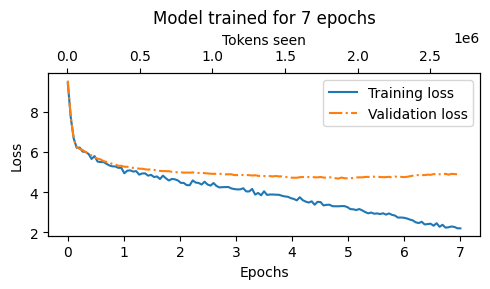

In [ ]:

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses,num_epochs)


## Function to geenrate text (Comprising of temperature and top k sampling)

In [ ]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      top_logits,_ = torch.topk(logits,top_k)
      min_value = top_logits[:, -1]
      logits = torch.where(
          logits < min_value,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples = 1)
    else:
      idx_next = torch.argmax(logits, dim = -1, keepdim = True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx,idx_next), dim = -1)
  return idx

In [ ]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Hello, I am", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M['context_length'],
    top_k = 25,
    temperature = 1.4
)
print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Hello, I am in dancing is, as you at
be renewed.”




## Saving the model

In [ ]:
torch.save({
    "epochs": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
  },
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Saving to Cloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save({
    "epochs": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "/content/drive/MyDrive/model_and_optimizer.pth")

## loading from cload and testing

In [ ]:
!git clone https://github.com/Bhavya171/LLM_From_Scratch

Cloning into 'LLM_From_Scratch'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 24), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 2.06 MiB | 5.09 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
%cd LLM_From_Scratch

/content/LLM_From_Scratch


In [ ]:
!pip install tiktoken

In [ ]:


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}



In [ ]:
import torch
import tiktoken
from previous_chapters import GPTModel
from previous_chapters import generate_text_simple

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1g-CgaIaFtRfTFkIhTmt_HRVwSDheSUNN -O model_and_optimizer.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1g-CgaIaFtRfTFkIhTmt_HRVwSDheSUNN
From (redirected): https://drive.google.com/uc?id=1g-CgaIaFtRfTFkIhTmt_HRVwSDheSUNN&confirm=t&uuid=ad20a703-06a6-45fd-84c8-5f0acc3efa4b
To: /content/LLM_From_Scratch/model_and_optimizer.pth
100% 1.95G/1.95G [00:15<00:00, 122MB/s]


In [ ]:
  # Importing the model architecture

model = GPTModel(GPT_CONFIG_124M)

checkpoint = torch.load("model_and_optimizer.pth", map_location="cuda", weights_only=False)  # Change to "cpu" if needed
model.load_state_dict(checkpoint["model_state_dict"])


model.eval()

print("✅ Model successfully loaded!")


✅ Model successfully loaded!


In [ ]:
# text to tokens




def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Every effort moves you know,” said Mr. Jaggers,


In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      top_logits,_ = torch.topk(logits,top_k)
      min_value = top_logits[:, -1]
      logits = torch.where(
          logits < min_value,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples = 1)
    else:
      idx_next = torch.argmax(logits, dim = -1, keepdim = True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx,idx_next), dim = -1)
  return idx

In [ ]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Hello, I am", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M['context_length'],
    top_k = 25,
    temperature = 1.4
)
print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Hello, I am, in your very glad to my opinion, I am, at Mr.
